In [1]:
import uproot
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm

import seaborn as sn

import torch

# 1 - Extracting Data and Moving to GPU

In [2]:
file = uproot.open("/snoplus simulations/electron bulk/random point/random dir/Low Statistic/simu_Analysis_elec_10MeV.root")
file.keys()

['T;6', 'T;5', 'pmt;2', 'pmt;1']

In [3]:
data1 = file['T;6']
data1.keys()

['evtid',
 'mcID',
 'energy',
 'mc_position',
 'mc_momentum',
 'position',
 'momentum',
 'hit_pmtid',
 'hit_pmttime',
 'hit_residual',
 'hit_type']

In [4]:
pmt_info = file['pmt;1']
pmt_info.keys()

['pmt_id', 'pmt_pos_xyz', 'pmt_pos_sph', 'pmt_type']

## 1.1 - EV info

In [5]:
evtid = torch.tensor(np.array(data1['evtid'])).cuda()
mcID = torch.tensor(np.array(data1['mcID'])).cuda()
mc_position = torch.tensor(np.array(data1['mc_position'])).cuda()
mc_momentum = torch.tensor(np.array(data1['mc_momentum'])).cuda()  # -> IMPORTANT: Direction of simulated event
position = torch.tensor(np.array(data1['position'])).cuda()
hit_pmtid = torch.tensor(np.array(data1['hit_pmtid'])).cuda()
hit_pmttime = torch.tensor(np.array(data1['hit_pmttime'])).cuda()
time_residual = torch.tensor(np.array(data1['hit_residual'])).cuda()
hit_type = torch.tensor(np.array(data1['hit_type'])).cuda()

## 1.1 - PMT info

In [6]:
pmt_id = torch.tensor(np.array(pmt_info['pmt_id'])).cuda()
pmt_pos_xyz = torch.tensor(np.array(pmt_info['pmt_pos_xyz'])).cuda()
pmt_pos_sph = torch.tensor(np.array(pmt_info['pmt_pos_sph'])).cuda()
pmt_type = torch.tensor(np.array(pmt_info['pmt_type'])).cuda()

# 2 - Observe Data - Time Residual

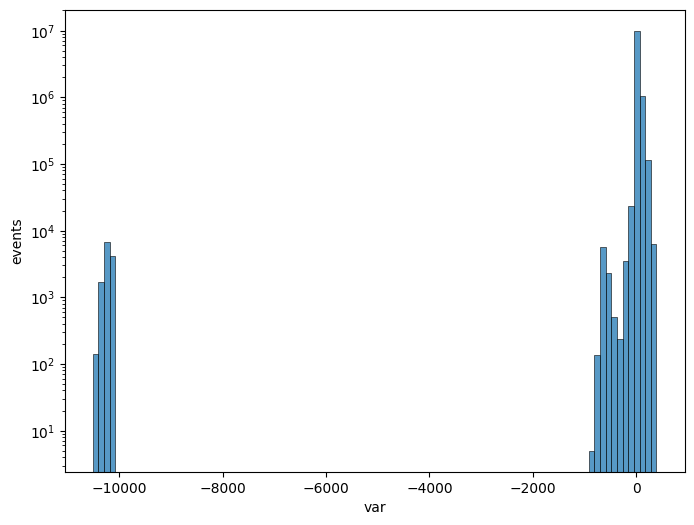

In [9]:
plt.figure(figsize=(8,6))
sn.histplot(time_residual.cpu(), bins = 100)
plt.xlabel('var')
plt.ylabel('events')
plt.yscale('log')

In [10]:
time_residual

tensor([-10276.7949,    -99.5628,    -42.4744,  ...,     48.7290,
            39.2709,   -570.9697], device='cuda:0', dtype=torch.float64)

# 3 - Extract Valid Data

## 3.1 - Extract  valid PMT id

In [9]:
## Numpy proofs to validate pytorch tools

valid_pmt_id = np.where(pmt_type.cpu() == 1)[0]   # PMT valid ID match with index of where pmt_type=1

valid_id_info_ev_i = np.where(np.in1d(hit_pmtid.cpu(), valid_pmt_id))[0]
valid_id_info_ev_i

array([       0,        1,        2, ..., 11158432, 11158433, 11158434],
      dtype=int64)

In [12]:
# Torch Tensor Method

valid_pmt_id = torch.where(pmt_type == 1)[0].cuda()  #pmt valid ID match with index of where pmt_type=1
#print(valid_pmt_id)

#Now, with valid_pmt_id, extract valid index of EV Data     
condition = (torch.isin(hit_pmtid,valid_pmt_id))
valid_id_info_ev_i = (torch.where(condition))[0] # --> index of valid info
print(valid_id_info_ev_i)

tensor([       0,        1,        2,  ..., 11158432, 11158433, 11158434],
       device='cuda:0')


## 3.2 - Extract valid info of EV

Use numpy type because Concatenates Faster!

In [10]:
# CONCATENATE DATA IN NUMPY ARRAY IS FASTER!
valid_pmt_id = np.where(pmt_type.cpu() == 1)[0]   #pmt valid ID match with index of where pmt_type=1
valid_pmt_id_ev = []

np_time_residual = np.array(data1['hit_residual'])
np_pmt_id_hit = np.array(data1['hit_pmtid'])         # Hit IDs to extract coordinates!
np_mc_momentum = np.array(data1['mc_momentum'])
np_xyz_pmt = np.array(pmt_info['pmt_pos_xyz'])


# With valid index data extract valid data

data_portion = 1   # percentage of data
lim_data = round(len(valid_id_info_ev_i)*data_portion)

multi_time_residual = []
multi_pmt_id_hit = []
multi_mc_momentum = []   #PENSAR BIEN COMO EXTRAER -> Se repite dentro de cada EV muchas veces -> Separar por evIDs
multi_xyz_hit = []

for valid_i in np_valid_id_info_ev_i[0:lim_data]:
    multi_time_residual.append(np_time_residual[valid_i])
    multi_mc_momentum.append(np_mc_momentum[valid_i])
    multi_pmt_id_hit.append(np_pmt_id_hit[valid_i])
    
multi_time_residual = np.array(multi_time_residual)   #Has to be an array to use numpoy tools bellow!

#extract xyz_hit from pmt_id_hit
for id_i in multi_pmt_id_hit:
    multi_xyz_hit.append(np_xyz_pmt[id_i])

In [11]:
len(multi_xyz_hit) == len(multi_mc_momentum)

True

### 3.2.3 - Construct Observable $cos(α)$

In [14]:
multi_cos_angle = []
N = np.shape(multi_xyz_hit)[0]

for k in range(N):
    cos_val = np.dot(multi_xyz_hit[k], multi_mc_momentum[k])/(np.linalg.norm(multi_mc_momentum[k])*np.linalg.norm(multi_xyz_hit[k]))
    multi_cos_angle.append(cos_val)
multi_cos_angle = np.array(multi_cos_angle)

In [15]:
cos_val

0.01385304119930079

# 4 - Plots

## 4.1 - Time residual vs. $cos(α)$

### 4.1.1 - cut time residual

In [16]:
up_cut = 20
inf_cut = -5

multi_time_res_cut = []
multi_cos_angle_cut = []

for i in np.where((multi_time_residual > inf_cut) & (multi_time_residual < up_cut))[0]:

    multi_time_res_cut.append(multi_time_residual[i])
    multi_cos_angle_cut.append(multi_cos_angle[i])

In [20]:
%matplotlib
# 2d Histogram
bins = 40

title = 'cos(α) vs. time residual - Multiple evID - 10MeV - random (dir,vtx)'

plt.figure(figsize=(10, 8))
#plt.figure(figsize=(8,8))
sn.set_style(rc = {'axes.facecolor': 'black'})
sn.histplot(x = multi_cos_angle_cut, y = multi_time_res_cut, bins = [bins, bins], stat='count', cbar = 'True', cmap = cm.nipy_spectral)
plt.ylabel('time residual')
plt.xlabel('cos(α)')
plt.title(title)

#equal acis ration
#ax = plt.gca()
#ax.set_aspect('equal', adjustable='box')
plt.show()
#plt.savefig('figs/Low Stat/' + title +'.png', format = 'png')

Using matplotlib backend: TkAgg


### 4.1.2 - Normalization

In [21]:
#Transforma Data into an Image Matrix
H, xedges, yedges = np.histogram2d(x = multi_cos_angle_cut, y = multi_time_res_cut, bins = [bins, bins])

#Now recover the data axis representation of time residual vs cos(alpha)
left = np.min(multi_time_res_cut)
right = np.max(multi_time_res_cut)
bottom = np.min(multi_cos_angle_cut)
top = np.max(multi_cos_angle_cut)

#Titles
title = 'cos(α) vs. time residual - Multiple evID - 10MeV - random (dir,vtx).'
ylabel = 'cos(α)'
xlabel = 'time residual'

plt.figure(figsize=(10, 8))
plt.imshow(H, extent = [left, right, top, bottom], aspect="auto" ) #---> Here is our image as a Matrix Pixel
plt.title(title)
plt.ylabel(ylabel)
plt.xlabel(xlabel)
plt.colorbar()

#plt.savefig('figs/Low Stat/' + title +'(imshow).png', format = 'png')

#### 4.1.2.1 - Normalization by Nhits

In [22]:
# sum of hits in each bin = sum over each column element of the matrix.
sum_hit = np.sum(H,axis=0)  

H_normalized1 = H / sum_hit

N1title = 'Normalization by NHits - Multiple evID - 10 MeV - random (dir,vtx)'

plt.figure(figsize=(10, 8))
plt.imshow(H_normalized1, extent = [left, right, top, bottom], aspect="auto" )
plt.title(N1title)
plt.ylabel(ylabel)
plt.xlabel(xlabel)
plt.colorbar()

#plt.savefig('figs/Low Stat/' + N1title +'.png', format = 'png')